In [10]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
from collections import Counter
from time import sleep
import networkx as nx

# Models Building

1. Retrieve homologous proteins starting from the given input sequence performing an NCBI BLAST search (https://www.ebi.ac.uk/jdispatcher/sss/ncbiblast) against UniProtKB/Swiss-Prot (The manually annotated section of UniProtKB).
Parameters:
- Sequence type: Protein
- Program: blastp
- Matrix (The substitution matrix used for scoring alignments when searching the database): BLOSUM62
- Gap open (Penalty taken away from the score when a gap is created in sequence. Increasing the gap opening penalty will decrease the number of gaps in the final alignment): 11
- Gap extend (Penalty taken away from the score for each base or residue in the gap. Increasing the gap extension penalty favors short gaps in the final alignment, conversly decreasing the gap extension penalty favors long gaps in the final alignment): 1
- Exp. thr (Limits the number of scores and alignments reported based on the expectation value. This is the maximum number of times the match is expected to occur by chance): 1e-5
- Scores (Maximum number of match score summaries reported in the result output): 1000
- Alignments (Maximum number of match alignments reported in the result output): 1000
- Sequence range (Specify a range or section of the input sequence to use in the search): Start-End
- HSPS (Maximum number of HSPs alignments to keep for any single query-subject pair): 100
- Word size (Word size for wordfinder algorithm): 6

Obtained 302 results (sequences) with E-value ranging from 2.5e-69 to 9.4e-6 Downloaded all the alignments in FASTA format. The resulting file is located in the 'data/blast' folder and is named blast_swissprot.fasta.

2. Generate a multiple sequence alignment (MSA) starting from retrieved hits using ClustalOmega and MUSCLE.

ClustalOmega (maximum 4000 sequences):
- Sequence type: Protein
- Output format: Pearson/FASTA
- Other default parameters

MUSCLE (maximum 500 sequences):
- Output format: Pearson/FASTA
- Other default parameters

Result Files -> Alignment in FASTA format (.aln-fasta) and The alignment in FASTA format converted by Seqret (.fa). The output files are inside 'data/msa' folder and are named: 'clustalo.fa' and 'muscle.fa'

3. Edit the MSA with JalView to remove not conserved positions (columns) and/or redundant information (rows)
- No refinement (Clustal Omega and MUSCLE - 302 sequences)
- Remove redundancy at 100% threshold and remove empty columns (Clustal Omega - 178 sequences, MUSCLE-277 sequences)
- Remove redundancy at 100% threshold, remove empty columns and remove poorly occupied columns (less than 15 percent) (Clustal Omega - 178 sequences, MUSCLE-277 sequences)
- Remove redundancy at 100% threshold, remove empty columns and remove columns with consensus below 10% (Clustal Omega - 178 sequences, MUSCLE-277 sequences)

The output files are inside 'data/msa_after_jalview' folder and are named: 'clustalo-1.fa', 'clustalo-2.fa', 'clustalo-3.fa', 'clustalo-4.fa',
'muscle-1.fa', 'muscle-2.fa', 'muscle-3.fa', 'muscle-4.fa'.

4. Build an HMM model starting from the MSA

The output files are inside the 'data/hmm' folder and are named: 'clustalo-1.hmm', 'clustalo-2.hmm', 'clustalo-3.hmm', 'clustalo-4.hmm',
'muscle-1.hmm', 'muscle-2.hmm', 'muscle-3.hmm', 'muscle-4.hmm'.


In [11]:
SWISSPROT_SIZE = 572619
SWISSPROT_LENGTH = 207431389
MSA = ["clustalo", "muscle"]

# Model evaluation

## Prediction

In this part we generate the prediction by running HMM-SEARCH against the SwissProt database, with our eight different models described previously. We collected the list of retrieved hits and the matching positions of our models in the retrieved hits. The output files ase inside the 'data/predictions' folder and are names: 'clustalo-1-hmmsearch.tsv', 'clustalo-2-hmmsearch.tsv', 'clustalo-3-hmmsearch.tsv', 'clustalo-4-hmmsearch.tsv', 'muscle-1-hmmsearch.tsv', 'muscle-2-hmmsearch.tsv', 'muscle-3-hmmsearch.tsv', 'muscle-4-hmmsearch.tsv'.

## Ground Truth

Next step is to define a ground truth to evaluate our results and this is done by finding all proteins in SwissProt annotated with the Pfam domain - PF00085, given in the file named 'protein-matching-PF00085/tsv'. To do this, we collect the set of SwissProt proteins matching the assigned Pfam domain, and also collect the matching positions of the Pfam domain in the sequences by performing a search for the domain by its id on the InterPro database. We found 474 proteins from SwissProt that contain the Thioredoxin domain.

In [ ]:
# Define the file path
file_path = "data/protein-matching-PF00085.tsv"

# Read the TSV file into a pandas DataFrame
gt_df = pd.read_csv(file_path, sep='\t')
unique_proteins = gt_df.shape[0]
print(f"Number of unique proteins with PF00085 domain: {unique_proteins}")

# Splitting the "Matches" column by comma to create multiple rows
gt_df = gt_df.assign(Matches=gt_df["Matches"].str.split(",")).explode("Matches")

# Splitting the "Matches" column by ".." into "Start" and "End"
gt_df[["Start", "End"]] = gt_df["Matches"].str.split("\.\.", expand=True)

# Dropping the old "Matches column"
gt_df = gt_df.drop(columns=["Matches"])

# Convert "Start" and "End" to integers
gt_df["Start"] = gt_df["Start"].astype(int)
gt_df["End"] = gt_df["End"].astype(int)

# Display the transformed DataFrame
display(gt_df)

Number of unique proteins with PF00085 domain: 474


,Accession,Source Database,Name,Tax ID,Tax Name,Length,Entry Accession,Start,End
0,A0A1L1SUL6,reviewed,Thioredoxin domain-containing protein 6,10090,Mus musculus,329,PF00085,14,109
1,A0A509AQW5,reviewed,Thioredoxin 2,5823,Plasmodium berghei (strain Anka),157,PF00085,59,154
2,A0A8M1N5Y4,reviewed,Protein disulfide-isomerase tmx3a,7955,Danio rerio,437,PF00085,32,121
3,A2YIW7,reviewed,Thioredoxin H-type,39946,Oryza sativa subsp. indica,122,PF00085,9,109
4,A2YUQ6,reviewed,"Thioredoxin-like protein CITRX, chloroplastic",39946,Oryza sativa subsp. indica,189,PF00085,83,182
...,...,...,...,...,...,...,...,...,...
469,Q9ZP20,reviewed,"Thioredoxin M5, chloroplastic",39947,Oryza sativa subsp. japonica,172,PF00085,67,167
470,Q9ZP21,reviewed,"Thioredoxin M-type, chloroplastic",4565,Triticum aestivum,175,PF00085,70,170
471,Q9ZPE9,reviewed,5'-adenylylsulfate reductase-like 6,3702,Arabidopsis thaliana,295,PF00085,79,156
472,Q9ZPH2,reviewed,Monothiol glutaredoxin-S17,3702,Arabidopsis thaliana,488,PF00085,16,102


## Evaluation

The evaluation of the models is done with two different methods:

1. A comparison at protein level, measuring the ability of our models to retrieve the same proteins matched by Pfam.
2. A comparison at residue level, measuring the ability of our models to match the same positions matched by Pfam.

The metrics used are precision, recall, F-score, balanced accuracy, MCC.

In [ ]:
def calculate_metrics(tp, tn, fp, fn):
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  fscore = 2 * (precision * recall) / (precision + recall)
  balanced_accuracy = 0.5 * ((tp / (tp + fn)) + (tn / (tn + fp)))
  mcc = ((tp * tn) - (fp * fn)) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
  data = [[precision, recall, fscore, balanced_accuracy, mcc]]
  data_df = pd.DataFrame(data, columns = ["Precision", "Recall", "F-score", "Balanced Accuracy", "MCC"])
  display(data_df)
  return {
      "Precision": precision,
      "Recall": recall,
      "F-score": fscore,
      "Balanced accuracy": balanced_accuracy,
      "MCC": mcc
  }

In [12]:
def read_tsv(file_path):
  df = pd.read_csv(file_path, sep="\t", na_values=["-", "NA"])
  return df

In [ ]:
def compare_at_protein_level(hmmsearch, ground_truth):
  # Convert protein lists to sets using the correct column names
  hmm_proteins = set(hmmsearch["Target Accession"])
  gt_proteins = set(ground_truth["Accession"])

  # Compute metrics
  # True Positives: proteins found in both sets
  tp = len(hmm_proteins.intersection(gt_proteins))
  # False Positives: found in HMMSEARCH, but not in ground truth
  fp = len(hmm_proteins - gt_proteins)
  # False Negatives: found in ground truth, but not retrieved by HMMSEARCH
  fn = len(gt_proteins - hmm_proteins)
  # True Negatives: SWISSPROT_SIZE - TP
  tn = SWISSPROT_SIZE - tp

  data = [[tp, fp, fn, tn]]
  data_df = pd.DataFrame(data, columns=['TP', 'FP', 'FN', 'TN'])
  display(data_df)
  return calculate_metrics(tp, tn, fp, fn)

In [ ]:
for msa in MSA:
  for i in range(1, 5):
    file_path = f"data/predictions/{msa}-{i}-hmmsearch.tsv"
    hmmsearch_df = read_tsv(file_path)
    results = compare_at_protein_level(hmmsearch_df, gt_df)
    print(f"Results for {msa}-{i}-hmmsearch.tsv:")
    print(results)

,TP,FP,FN,TN
0,439,97,35,572180


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.81903,0.92616,0.869307,0.962995,0.870837


Results for clustalo-1-hmmsearch.tsv:
{'Precision': 0.8190298507462687, 'Recall': 0.9261603375527426, 'F-score': 0.8693069306930693, 'Balanced accuracy': 0.9629954196076995, 'MCC': 0.8708372407318762}


,TP,FP,FN,TN
0,436,103,38,572183


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.808905,0.919831,0.860809,0.959826,0.862467


Results for clustalo-2-hmmsearch.tsv:
{'Precision': 0.8089053803339518, 'Recall': 0.919831223628692, 'F-score': 0.8608094768015794, 'Balanced accuracy': 0.959825621844296, 'MCC': 0.8624672555723863}


,TP,FP,FN,TN
0,443,104,31,572176


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.809872,0.934599,0.867777,0.967209,0.86989


Results for clustalo-3-hmmsearch.tsv:
{'Precision': 0.8098720292504571, 'Recall': 0.9345991561181435, 'F-score': 0.8677766895200785, 'Balanced accuracy': 0.9672087134473433, 'MCC': 0.8698895990309423}


,TP,FP,FN,TN
0,444,103,30,572175


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.8117,0.936709,0.869736,0.968264,0.871855


Results for clustalo-4-hmmsearch.tsv:
{'Precision': 0.8117001828153565, 'Recall': 0.9367088607594937, 'F-score': 0.8697355533790402, 'Balanced accuracy': 0.9682644391517072, 'MCC': 0.8718552406682449}


,TP,FP,FN,TN
0,430,90,44,572189


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.826923,0.907173,0.865191,0.953508,0.866004


Results for muscle-1-hmmsearch.tsv:
{'Precision': 0.8269230769230769, 'Recall': 0.9071729957805907, 'F-score': 0.8651911468812877, 'Balanced accuracy': 0.9535078649158196, 'MCC': 0.8660037506259183}


,TP,FP,FN,TN
0,430,89,44,572189


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.828516,0.907173,0.866062,0.953509,0.866839


Results for muscle-2-hmmsearch.tsv:
{'Precision': 0.8285163776493256, 'Recall': 0.9071729957805907, 'F-score': 0.866062437059416, 'Balanced accuracy': 0.9535087384796592, 'MCC': 0.8668385618491912}


,TP,FP,FN,TN
0,440,84,34,572179


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.839695,0.92827,0.881764,0.964062,0.882771


Results for muscle-3-hmmsearch.tsv:
{'Precision': 0.8396946564885496, 'Recall': 0.9282700421940928, 'F-score': 0.8817635270541081, 'Balanced accuracy': 0.9640616282689236, 'MCC': 0.8827711999423898}


,TP,FP,FN,TN
0,446,84,28,572173


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.841509,0.940928,0.888446,0.970391,0.889736


Results for muscle-4-hmmsearch.tsv:
{'Precision': 0.8415094339622642, 'Recall': 0.9409282700421941, 'F-score': 0.8884462151394422, 'Balanced accuracy': 0.9703907414234653, 'MCC': 0.8897361727216047}


In [ ]:
# Convert to dictionary mapping each protein to a list of residue ranges
def get_residue_ranges(df, protein_col, start_col, end_col):
  protein_residues = {}
  for _, row in df.iterrows():
    protein = row[protein_col]
    start, end = row[start_col], row[end_col]
    if protein not in protein_residues:
      protein_residues[protein] = set()
    # Store all residue positions
    protein_residues[protein].update(range(start, end+1))
  return protein_residues

In [ ]:
def compare_at_residue_level(hmmsearch, ground_truth):
  # Extract residue mappings from both dataframes
  hmm_residues = get_residue_ranges(hmmsearch, "Target Accession", "Target Ali. Start", "Target Ali. End")
  gt_residues = get_residue_ranges(ground_truth, "Accession", "Start", "End")

  # Initialize TP, TN, FP, FN
  tp, tn, fp, fn = 0, 0, 0, 0

  # Calculate metrics for proteins in both dataframes
  all_proteins = set(hmm_residues.keys()).union(set(gt_residues.keys()))

  for protein in all_proteins:
    predicted_residues = hmm_residues.get(protein, set())
    actual_residues = gt_residues.get(protein, set())

    tp += len(predicted_residues.intersection(actual_residues))
    fp += len(predicted_residues - actual_residues)
    fn += len(actual_residues - predicted_residues)

  tn = SWISSPROT_LENGTH - tp - fp - fn

  data = [[tp, fp, fn, tn]]
  data_df = pd.DataFrame(data, columns=['TP', 'FP', 'FN', 'TN'])
  display(data_df)
  return calculate_metrics(tp, tn, fp, fn)

In [ ]:
for msa in MSA:
  for i in range(1, 5):
    file_path = f"data/predictions/{msa}-{i}-hmmsearch.tsv"
    hmmsearch_df = read_tsv(file_path)
    results = compare_at_residue_level(hmmsearch_df, gt_df)
    print(f"Results for {msa}-{i}-hmmsearch.tsv:")
    print(results)

,TP,FP,FN,TN
0,52288,56753,3866,207318482


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.479526,0.931154,0.633046,0.96544,0.668105


Results for clustalo-1-hmmsearch.tsv:
{'Precision': 0.47952604983446595, 'Recall': 0.9311536132777718, 'F-score': 0.6330457943642362, 'Balanced accuracy': 0.9654399701453673, 'MCC': 0.6681046491750511}


,TP,FP,FN,TN
0,51739,56663,4415,207318572


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.477288,0.921377,0.628832,0.960552,0.663033


Results for clustalo-2-hmmsearch.tsv:
{'Precision': 0.4772882419143558, 'Recall': 0.9213769277344446, 'F-score': 0.6288315223996694, 'Balanced accuracy': 0.9605518443716494, 'MCC': 0.6630326877800667}


,TP,FP,FN,TN
0,52396,45288,3758,207329947


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.536383,0.933077,0.681184,0.966429,0.707356


Results for clustalo-3-hmmsearch.tsv:
{'Precision': 0.5363826215142705, 'Recall': 0.9330768956797378, 'F-score': 0.6811841027574461, 'Balanced accuracy': 0.966429254473554, 'MCC': 0.707355769133069}


,TP,FP,FN,TN
0,52273,31972,3881,207343263


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.620488,0.930886,0.744635,0.965366,0.759928


Results for clustalo-4-hmmsearch.tsv:
{'Precision': 0.620487862781174, 'Recall': 0.9308864907219432, 'F-score': 0.7446349332972457, 'Balanced accuracy': 0.9653661580462785, 'MCC': 0.7599280786640568}


,TP,FP,FN,TN
0,51332,56574,4822,207318661


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.47571,0.914129,0.625771,0.956928,0.659325


Results for muscle-1-hmmsearch.tsv:
{'Precision': 0.4757103404815302, 'Recall': 0.9141290023862948, 'F-score': 0.6257710593685236, 'Balanced accuracy': 0.956928096284432, 'MCC': 0.6593250986731093}


,TP,FP,FN,TN
0,51329,56656,4825,207318579


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.475335,0.914076,0.625433,0.956901,0.659045


Results for muscle-2-hmmsearch.tsv:
{'Precision': 0.47533453720424135, 'Recall': 0.9140755778751292, 'F-score': 0.6254333217577785, 'Balanced accuracy': 0.9569011863196097, 'MCC': 0.65904518899513}


,TP,FP,FN,TN
0,52130,46256,4024,207328979


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.529852,0.92834,0.674647,0.964058,0.701246


Results for muscle-3-hmmsearch.tsv:
{'Precision': 0.5298518081840913, 'Recall': 0.9283399223563771, 'F-score': 0.6746473404943705, 'Balanced accuracy': 0.9640584338784124, 'MCC': 0.7012463100309321}


,TP,FP,FN,TN
0,52621,14907,3533,207360328


,Precision,Recall,F-score,Balanced Accuracy,MCC
0,0.779247,0.937084,0.850908,0.968506,0.854487


Results for muscle-4-hmmsearch.tsv:
{'Precision': 0.7792471271176401, 'Recall': 0.937083734017167, 'F-score': 0.8509079736744232, 'Balanced accuracy': 0.968505924915498, 'MCC': 0.8544868796792036}


# Taxonomy

In this part we collect the taxonomic lineage from UniProt for each protein in the defined protein family by our best model. Then, we plot the taxonomic tree of the family with node sizes proportional to their relative abundance.



In [ ]:
# Function to fetch XML data from UniProt
def fetch_uniprot_xml(accession):
    url = f"https://www.uniprot.org/uniprot/{accession}.xml"
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to fetch {accession}: {response.status_code}")
        return None

# Function to parse XML and extract taxonomy details
def parse_uniprot_xml(xml_data):
    root = ET.fromstring(xml_data)
    lineage = [node.text for node in root.findall(".//{http://uniprot.org/uniprot}lineage/{http://uniprot.org/uniprot}taxon")]
    return " > ".join(lineage) if lineage else "N/A"

In [13]:
best_hmm = read_tsv("data/predictions/muscle-4-hmmsearch.tsv")
protein_ids = best_hmm["Target Accession"].unique().tolist()

In [15]:
# Collect taxonomy lineage data
lineage_counter = Counter()
for protein_id in protein_ids:
    xml_data = fetch_uniprot_xml(protein_id)
    if xml_data:
        lineage_path = parse_uniprot_xml(xml_data)
        if lineage_path != "N/A":
            lineage_counter[lineage_path] += 1
    sleep(1)

# Convert to DataFrame and compute relative abundance
df = pd.DataFrame(lineage_counter.items(), columns=["Lineage", "Count"])
df["Relative_Abundance"] = df["Count"] / df["Count"].sum()

# Save to CSV
df.to_csv("uniprot_taxonomy_abundance.csv", index=False)
print(df.head())

                                             Lineage  Count  \
0  Eukaryota > Metazoa > Chordata > Craniata > Ve...     10   
1  Eukaryota > Metazoa > Chordata > Craniata > Ve...     30   
2  Eukaryota > Metazoa > Chordata > Craniata > Ve...     30   
3  Eukaryota > Metazoa > Chordata > Craniata > Ve...     20   
4  Eukaryota > Metazoa > Chordata > Craniata > Ve...      6   

   Relative_Abundance  
0            0.018868  
1            0.056604  
2            0.056604  
3            0.037736  
4            0.011321  


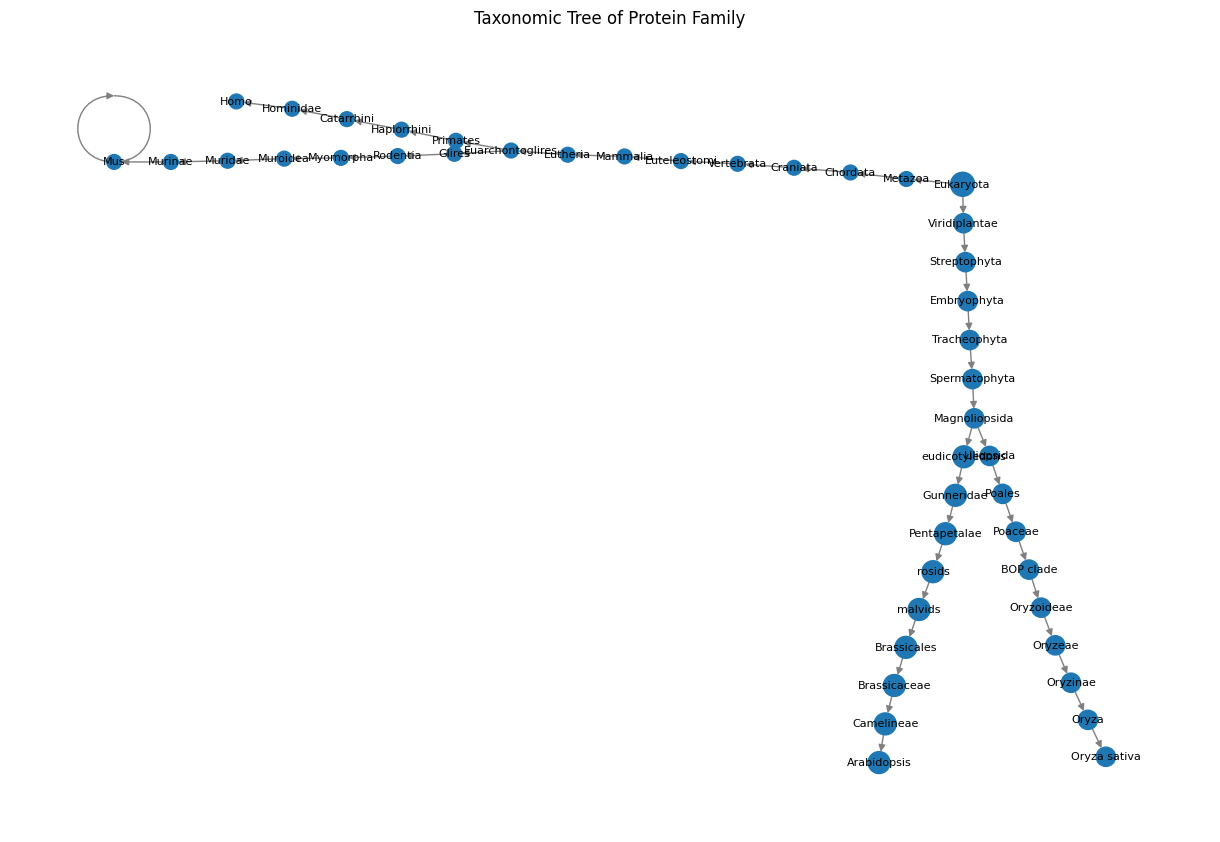

In [20]:
# Set threshold for visibility
ABUNDANCE_THRESHOLD = 0.05  # Adjust based on dataset

# Build hierarchical tree
G = nx.DiGraph()
node_sizes = {}

for lineage, count in lineage_counter.items():
    abundance = count / sum(lineage_counter.values())
    if abundance < ABUNDANCE_THRESHOLD:
        continue  # Skip nodes below threshold

    taxa = lineage.split(" > ")
    for i in range(len(taxa) - 1):
        parent, child = taxa[i], taxa[i + 1]
        G.add_edge(parent, child)
        node_sizes[child] = abundance * 2000  # Scale for visibility

# Plot the tree
plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(G)  # Layout for hierarchy
nx.draw(G, pos, with_labels=True, node_size=[node_sizes.get(node, 300) for node in G.nodes()], font_size=8, edge_color="gray")
plt.title("Taxonomic Tree of Protein Family")
plt.show()